# Set up the environment

## Config items
Variables that need to be configured according to user requirements

In [ ]:
# GCP Project ID
PROJECT_ID=""
# GCP Region
GCP_REGION="us-central1"
# Categories or drawings that we want to recognise or classify
CATEGORIES_TO_PROCESS=["basketball", "cat", "owl", "airplane", "bucket", "diamond"]

In [49]:
# Basic setup
# Import required libraries
import kfp
from kfp.v2 import compiler
from kfp.v2.dsl import pipeline, component, Dataset, Input, Output
from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip
# Environment config
BUCKET_NAME=""
IMAGES_BUCKET="images"
PIPELINE_ROOT=""

# Check that the environment has configured a GCP project
def is_project_configured():
    global PROJECT_ID
    # project_id = os.environ["GCP_PROJECT"]
    system_out = !gcloud config get project
    project_id = system_out[0]
    
    # Check if the project is not set
    check = not (project_id=="" or project_id.strip()=="")
    return check

# Ensure that a bucket exists.  
def ensure_bucket_exists(bucket_name):
    from google.cloud import storage
    
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    # Check if the GCS bucket already exists
    if bucket.exists():
        print("Bucket exists: " + bucket_name)
    else:
        # Doesn't exist, so create one
        print("Creating bucket: " + bucket_name)
        bucket.create()
    
    return

def env_setup():
    from google.cloud import storage
    from datetime import datetime
    import os
    import sys
    
    global BUCKET_NAME, PIPELINE_ROOT
    # Check project ID is set
    if is_project_configured():
        # Project ID is set
        print("Using project: " + project_id)
        time_stamp = datetime.now().strftime("%Y%m%d%H%M%S")
        BUCKET_NAME=project_id + "-qd"
        ensure_bucket_exists(BUCKET_NAME)
        # gcs_client = storage.Client()
        # bucket = gcs_client.bucket(BUCKET_NAME)
        # # Check if the GCS bucket already exists
        # if bucket.exists()==False:
        #     # Doesn't exist, so create one
        #     print("Creating bucket: " + BUCKET_NAME)
        #     bucket.create()
        # # Set the pipeline root for vertex AI
        PIPELINE_ROOT = f"{BUCKET_NAME}/{time_stamp}/pipeline-root/"
        print("Pipeline root is: " + PIPELINE_ROOT)
    else:
        # Exit with error that project ID has not been configured
        sys.exit("Set project using `gcloud config set project [project-id]`")
    return

env_setup()

def enable_notebook_autocompletion():
    !pip install jupyter_contrib_nbextensions
    !jupyter contrib nbextension install - user
    from jedi import settings
    settings.case_insensitive_completion = True
    return
#enable_notebook_autocompletion()

Using project: scratch-pad-kunall
Bucket exists: scratch-pad-kunall-qd
Pipeline root is: scratch-pad-kunall-qd/20220712053849/pipeline-root/


# Data Flow Pipeline to create images

In [55]:
!pip install apache-beam[interactive]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 62.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.7/186.7 kB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=a467b02aaa526d65da85ce56a28c62f6ce182d24e2c30ccbdc7f646b27a8c461
  Stored in directory: /home/jupyter/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for timeloop: filename=timeloop-1.0.2-py3-none-any.whl size=3720 sha256=09936c09476f44714350c59d53f4ae6315ac22fcd467cac5a594e11082d98e16
  Stored in directory: /home/jupyter/.cache/pip/wheels/3a/7e/fc/5e4d6da12b9ab6550604412936723ec6f2faf7391dd6726a01
Successfully built dill timeloop
  Attempting uninsta

checking if the file exists


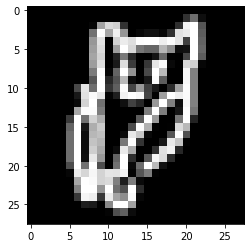

In [251]:
import argparse, json, io, base64, sys, uuid

import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.io import WriteToText
from apache_beam.io import filesystems
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions

from PIL import Image, ImageDraw
import numpy as np
from typing import Iterable

from io import BytesIO
from tensorflow.python.lib.io import file_io

class EncodeFn(beam.DoFn):
    def process(self, element, img_size=28, lw=3):
        import matplotlib.pyplot as plt
        %matplotlib inline  
        plt.imshow(element.reshape(28,28),cmap='gray', vmin=0, vmax=255) 
        image_data = Image.fromarray(element.reshape(28,28))
        b = io.BytesIO()
        image_data.convert('RGB').save(b, format='png')
        yield {'image':b.getvalue()}

class WriteToSeparateFiles(beam.DoFn):
    def __init__(self, outdir, category):
        self.outdir = outdir
        self.category = category
        
    def process(self, element):
        file_name = uuid.uuid4().hex + '.png'
        writer = filesystems.FileSystems.create(self.outdir + file_name )
        writer.write(element['image'])
        writer.close()
        yield self.outdir + file_name + "," + self.category

class WriteSavedImages(beam.DoFn):
    def __init__(self, file_name):
        self.file_name = file_name
        
    def process(self, element):
        original_content = ""
        with beam.io.gcsio.GcsIO().open(filename=self.file_name, mode="a") as f:
            f.write(element.encode("utf-8"))
        # saved_images_file = filesystems.FileSystems.create(self.file_name, mime_type="text/txt")
        # saved_images_file.write(bytes(element, encoding='UTF-8'))
        # saved_images_file.close()
        
# # def ensureFileExists(file_name) -> Iterable[str]:
# class EnsureFileExists(beam.DoFn):
#     def __init__(self, file_name):
#         self.file_name = file_name

#     def process(self, file_name):
def ensureFileExists(file_name):
        print("checking if the file exists")
        if not filesystems.FileSystems.exists(file_name):
            print("file doesn't exit. creating one")
            # Create an empty file if it doesn't exist
            original_file = filesystems.FileSystems.create(file_name, mime_type="text/txt")
            original_file.write(bytes("", encoding='UTF-8'))
            original_file.close()
      
        
def run(argv=None):
    parser = argparse.ArgumentParser()
    parser.add_argument('--category',
                      dest='category',
                      required=True,
                      help='Category of the drawing')
    parser.add_argument('--sample-size',
                      dest='size',
                      nargs="?",
                      const=4000,
                      help='Number of samples to be created')
    parser.add_argument('--input',
                      dest='input',
                      required=True,
                      help='GCS destination folder to read the ndjson file from (example: gs://BUCKET_NAME/path/to/')
    parser.add_argument('--output',
                      dest='output',
                      required=True,
                      help='GCS destination folder to save the images to (example: gs://BUCKET_NAME/path/to/images/')
    known_args, pipeline_args = parser.parse_known_args(argv)

    np_file = np.load(BytesIO(file_io.read_file_to_string(known_args.input + known_args.category+".npy", binary_mode=True))).astype("float32")
    idx = np.random.randint(len(np_file), size=int(known_args.size))
    np_file = np_file[idx,:]
    # print (np_file.shape)
    # Use save_main_session option because EncodeFn relies on global context (Image module imported)
    ensureFileExists(known_args.output+"saved_images.txt")
    
    with beam.Pipeline(argv=pipeline_args) as p:
        
        images = (
            p | "Read Numpy file from GCS" >> beam.Create(np_file) # TODO: create a seperate DoFn class for this
              | "Convert to images" >> beam.ParDo(EncodeFn())
              | "Save images to GCS" >> beam.ParDo(WriteToSeparateFiles(known_args.output+known_args.category+"/" , known_args.category))
              # | beam.Map(print)
              # | "Write to file" >> beam.io.WriteToText(known_args.output+"saved_images", file_name_suffix='.txt_temp',append_trailing_newlines=True,shard_name_template='')
              # | "List saved images" >> beam.Map(print)
        )
        # ensure_saved_images_file_exists = (
        #     p | "Create saved images file if it doesn't exist" >> beam.ParDo(EnsureFileExists(known_args.output+"saved_images.txt"))
        # )
        original_file = (
            p | "Read existing saved images file" >> beam.io.ReadFromText(known_args.output+"saved_images.txt")
            # p | "Read existing saved images file" >> beam.Create(beam.ParDo(EnsureFileExists(known_args.output+"saved_images.txt")))
        )
        
        merged = (
            (images,original_file) | beam.Flatten() |
            # beam.ParDo(WriteSavedImages(known_args.output+"saved_images"))
             beam.io.WriteToText(known_args.output+"saved_images", file_name_suffix='.txt',append_trailing_newlines=True,shard_name_template='')
        )

    result = p.run()
    # result.wait_until_finish()
    
# def image_map(image_file):
#     name = known_args.output + known_args.category + "/" + image_file + "," + known_args.category
#     print(name)
#     return name

if __name__ == '__main__':
    # run(["--input=gs://quickdraw_dataset/full/simplified/owl.ndjson", "--output=gs://scratch-pad-kunall-qd/images/"])
    run(["--category=owl", "--sample-size=20", "--input=gs://scratch-pad-kunall-qd/full/numpy_bitmap/", "--output=gs://scratch-pad-kunall-qd/images/"])


In [52]:
# @component(
#     packages_to_install=[
#         "google-cloud-storage",
#         "pandas",
#     ],
#     base_image="python:3.9",
#     output_component_file="preprocess_drawings.yaml"
# )
def preprocess_drawings(
    project=project_id,
    display_name="categories",
    categories=CATEGORIES_TO_PROCESS,
    categories_dataset = Output[Dataset]        
    ):
    import json
    import pandas as pd
    global BUCKET_NAME, IMAGES_BUCKET
    ensure_bucket_exists(BUCKET_NAME)
    for category in categories:
        print(f"Read from: gs://scratch-pad-kunall-qd/full/simplified/{category}.ndjson")
        with open(f'gs://scratch-pad-kunall-qd/full/simplified/{category}.ndjson', 'r') as f:
            data = json.load(f)
        pd.DataFrame(data).head
        print(f"gs://{BUCKET_NAME}/{IMAGES_BUCKET}/{category}/key.png,{category}")
            
    return
preprocess_drawings()

Bucket exists: scratch-pad-kunall-qd
Read from: gs://scratch-pad-kunall-qd/full/simplified/basketball.ndjson


FileNotFoundError: [Errno 2] No such file or directory: 'gs://scratch-pad-kunall-qd/full/simplified/basketball.ndjson'

In [ ]:
import kfp
from kfp.v2 import compiler
from kfp.v2.dsl import pipeline, component, Dataset, Input, Output
from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip


project_id = "scratch-pad-kunall"
from datetime import datetime
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET_NAME="gs://" + project_id + "-quickdraw-" + TIMESTAMP
PIPELINE_ROOT = f"{BUCKET_NAME}/qd-pipeline-root/"
pipeline_root_path = PIPELINE_ROOT

# Define the workflow of the pipeline.
@kfp.dsl.pipeline(
    name="automl-image-training-v2",
    pipeline_root=pipeline_root_path,)
def pipeline(project_id: str):
    # The first step of your workflow is a dataset generator.
    # This step takes a Google Cloud pipeline component, providing the necessary
    # input arguments, and uses the Python variable `ds_op` to define its
    # output. Note that here the `ds_op` only stores the definition of the
    # output but not the actual returned object from the execution. The value
    # of the object is not accessible at the dsl.pipeline level, and can only be
    # retrieved by providing it as the input to a downstream component.
    ds_op = gcc_aip.ImageDatasetCreateOp(
        project=project_id,
        display_name="flowers",
        gcs_source="gs://cloud-samples-data/vision/automl_classification/flowers/all_data_v2.csv",
        import_schema_uri=aiplatform.schema.dataset.ioformat.image.single_label_classification,
    )

    # The second step is a model training component. It takes the dataset
    # outputted from the first step, supplies it as an input argument to the
    # component (see `dataset=ds_op.outputs["dataset"]`), and will put its
    # outputs into `training_job_run_op`.
    training_job_run_op = gcc_aip.AutoMLImageTrainingJobRunOp(
        project=project_id,
        display_name="train-iris-automl-mbsdk-1",
        prediction_type="classification",
        model_type="CLOUD",
        #base_model=None,
        dataset=ds_op.outputs["dataset"],
        model_display_name="iris-classification-model-mbsdk",
        training_fraction_split=0.6,
        validation_fraction_split=0.2,
        test_fraction_split=0.2,
        budget_milli_node_hours=8000,
    )

    # The third and fourth step are for deploying the model.
    create_endpoint_op = gcc_aip.EndpointCreateOp(
        project=project_id,
        display_name = "create-endpoint",
    )

    model_deploy_op = gcc_aip.ModelDeployOp(
        model=training_job_run_op.outputs["model"],
        endpoint=create_endpoint_op.outputs['endpoint'],
        automatic_resources_min_replica_count=1,
        automatic_resources_max_replica_count=1,
    )

In [ ]:
from kfp.v2 import compiler
compiler.Compiler().compile(pipeline_func=pipeline,
        package_path='image_classif_pipeline.json')

In [ ]:
import google.cloud.aiplatform as aip

job = aip.PipelineJob(
    display_name="automl-image-training-v2",
    template_path="image_classif_pipeline.json",
    pipeline_root=pipeline_root_path,
    parameter_values={
        'project_id': project_id
    }
)

job.submit()